In [ ]:
# tracks={}
# for no in ['A','B','C','D']:
#     tracks[no] = pd.read_csv("dataset/track_" + no + ".csv", parse_dates=["date"])

In [67]:
import pandas_profiling as pdp

In [68]:
summarys = {}
for no in ['A', 'B', 'C', 'D']:
    summarys[no] = pd.read_csv(f'summary4_{no}.csv', index_col=0)

In [69]:
for no in ['A', 'B', 'C', 'D']:
    summarys[no].loc[summarys[no]['傾き'] == -100, '傾き'] = np.median(summarys[no].loc[summarys[no]['傾き'].notnull(), '傾き'])
    summarys[no].loc[summarys[no]['傾き'].isnull(), '傾き'] = np.median(summarys[no].loc[summarys[no]['傾き'].notnull(), '傾き'])
    summarys[no].loc[summarys[no]['切片'].isnull(), '切片'] = np.median(summarys[no].loc[summarys[no]['切片'].notnull(), '切片'])

In [70]:
import datetime

# DNN系

In [ ]:
from fbprophet import Prophet

In [ ]:
summarys['A'].dropna()

In [ ]:
[i for i in range(0, len(summary), 10)]

In [ ]:
data = pd.DataFrame(columns=['ds', 'y'])
# summary = summarys['A'].dropna().loc[10000:10200, '切片'].values
summary = summarys['A'].loc[10000:10200, '切片'].values
# summary = summarys['A'].dropna()

data['ds'] = [datetime.datetime(1900, 1, 1) + datetime.timedelta(days=i) for i in range(len(summary))]
data['y'] = summary
# data['ds'] = [datetime.date(1900, 1, 1) + datetime.timedelta(days=i) for i in range(0, len(summary)*100, 100)]
# data['y'] = summary*100
model = Prophet()
#model.add_seasonality(name='monthly', period=30.5, fourier_order=5)
model.fit(data)

In [ ]:
future = model.make_future_dataframe(periods=180)
forecast = model.predict(future)
model.plot(forecast)
plt.show()

In [ ]:
model.plot_components(forecast)
plt.show()

In [ ]:
# add change rates to changepoints
df_changepoints = data.loc[model.changepoints.index]
df_changepoints['delta'] = model.params['delta'].ravel()

# get changepoints
df_changepoints['ds'] = df_changepoints['ds'].astype(str)
df_selection = df_changepoints[df_changepoints['delta'] != 0]
date_changepoints = df_selection['ds'].astype('datetime64[ns]').reset_index(drop=True)

# plot
sns.set(style='whitegrid')
ax = sns.factorplot(x='ds', y='delta', data=df_changepoints, kind='bar', color='royalblue', size=4, aspect=2)
ax.set_xticklabels(rotation=90)

In [ ]:
import statsmodels.api as sm

data = pd.DataFrame(columns=['ds', 'y'])
summary = summarys['A'].loc[10000:10200, '切片'].values

data['ds'] = [datetime.datetime(2000, 1, 1) + datetime.timedelta(days=i) for i in range(len(summary))]
data['y'] = summary

# res = sm.tsa.seasonal_decompose(data)
res = sm.tsa.seasonal_decompose(summary, freq=10)
res.plot()

In [34]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

In [5]:
from sklearn.preprocessing import MinMaxScaler

In [6]:
def make_dataset(low_data):

    data, target = [], []
#     maxlen = 25
    maxlen = 50

    for i in range(len(low_data)-maxlen):
        data.append(low_data[i:i + maxlen])
        target.append(low_data[i + maxlen])

    re_data = np.array(data).reshape(len(data), maxlen, 1)
    re_target = np.array(target).reshape(len(data), 1)

    return re_data, re_target

In [7]:
# summary = summarys['A'].loc[0:1000, '切片'].values
summary = summarys['A'].loc[10000:10500, '傾き'].values

# normalize the dataset
scaler = MinMaxScaler()
summary = scaler.fit_transform([[i] for i in summary])

#g -> 学習データ，h -> 学習ラベル
g, h = make_dataset(summary)

In [35]:
# モデル構築

# 1つの学習データのStep数(maxlen)
length_of_sequence = g.shape[1] 
in_out_neurons = 1
n_hidden = 20

model = Sequential()
model.add(LSTM(n_hidden, input_shape=(length_of_sequence, in_out_neurons), return_sequences=False))
model.add(Dropout(0.25))
model.add(Dense(in_out_neurons))
model.add(Activation("linear"))
# optimizer = Adam(lr=0.0001)
# model.compile(loss="mean_squared_error", optimizer=optimizer)
model.compile(loss="mean_squared_error", optimizer='adam')

In [36]:
early_stopping = EarlyStopping(monitor='val_loss', mode='auto', patience=10)
model.fit(g, h,
          batch_size=1,
          epochs=50,
          validation_split=0.1,
          callbacks=[early_stopping]
          )

Train on 405 samples, validate on 46 samples
Epoch 1/50
405/405 [==============================] - 19s 46ms/step - loss: 0.0298 - val_loss: 0.0028
Epoch 2/50
405/405 [==============================] - 17s 42ms/step - loss: 0.0101 - val_loss: 0.0027
Epoch 3/50
405/405 [==============================] - 18s 44ms/step - loss: 0.0092 - val_loss: 0.0027
Epoch 4/50
405/405 [==============================] - 18s 45ms/step - loss: 0.0086 - val_loss: 0.0039
Epoch 5/50
405/405 [==============================] - 17s 41ms/step - loss: 0.0083 - val_loss: 0.0034
Epoch 6/50
405/405 [==============================] - 16s 40ms/step - loss: 0.0078 - val_loss: 0.0025
Epoch 7/50
405/405 [==============================] - 17s 42ms/step - loss: 0.0075 - val_loss: 0.0027
Epoch 8/50
405/405 [==============================] - 17s 42ms/step - loss: 0.0072 - val_loss: 0.0024
Epoch 9/50
405/405 [==============================] - 17s 42ms/step - loss: 0.0066 - val_loss: 0.0025
Epoch 10/50
405/405 [================

In [37]:
# 予測
predicted = model.predict(g)

<Figure size 1440x576 with 0 Axes>

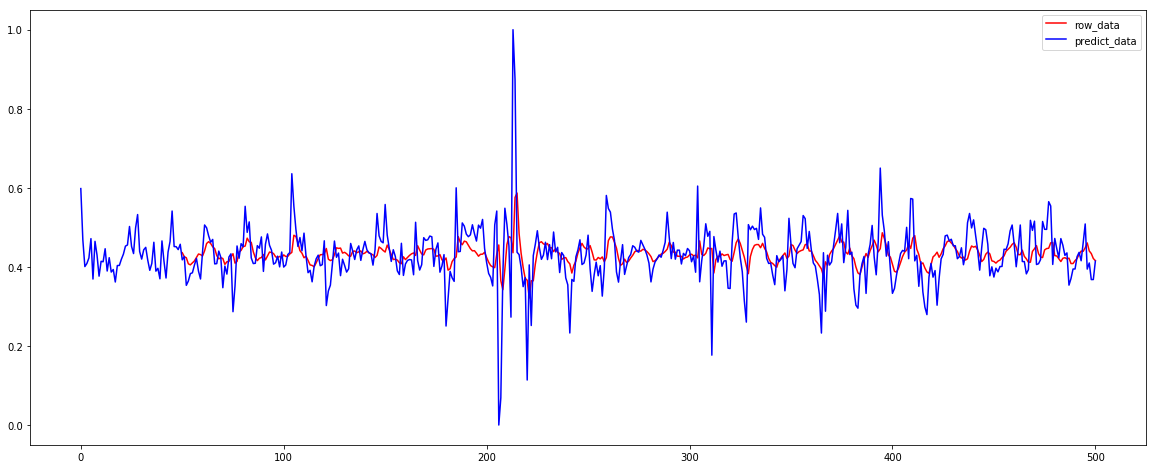

In [38]:
plt.figure(figsize=(20, 8))
plt.plot(range(50,len(predicted)+50), predicted, color="r", label="row_data")
plt.plot(range(0, len(summary)), summary, color="b", label="predict_data")
plt.legend()
plt.show()

# ARIMAとか古典的手法

In [24]:
summary = summarys['A'].loc[10000:10500, '傾き'].fillna(0).values

num=3.0
b = np.ones(int(num))/num
ma = np.convolve(summary.reshape(len(summary)), b, mode='same')

<Figure size 1440x576 with 0 Axes>

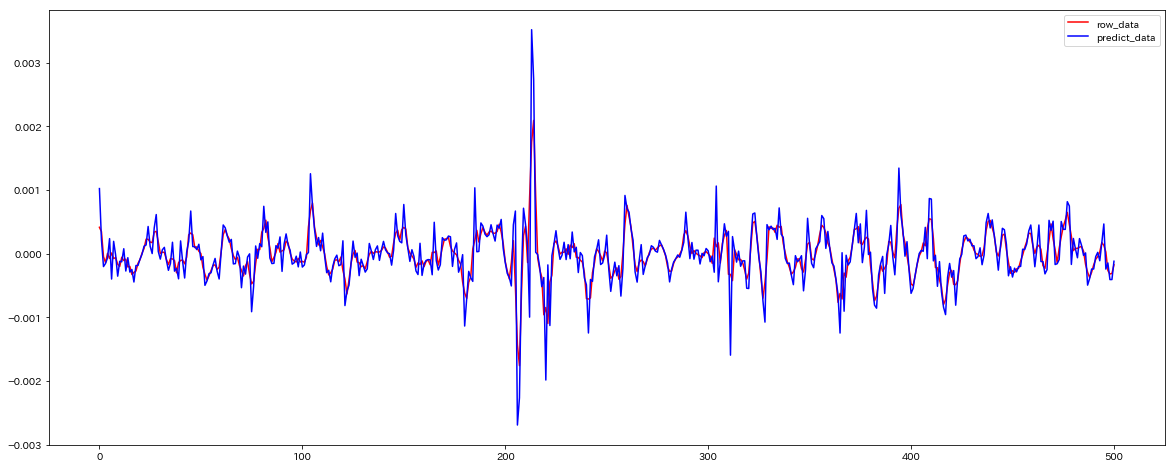

In [25]:
plt.figure(figsize=(20, 8))
plt.plot(range(len(summary)), ma, color="r", label="row_data")
plt.plot(range(len(summary)), summary, color="b", label="predict_data")
plt.legend()
plt.show()

In [71]:
from statsmodels.tsa import stattools as st
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARMA,ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [82]:
# maxlag = 150
# ar = AR(summary).fit(maxlag=maxlag, ic='aic')
ar = AR(summary).fit()
ar_predict = ar.predict()

In [83]:
len(summary)
len(ar_predict)

501

483

<Figure size 1440x576 with 0 Axes>

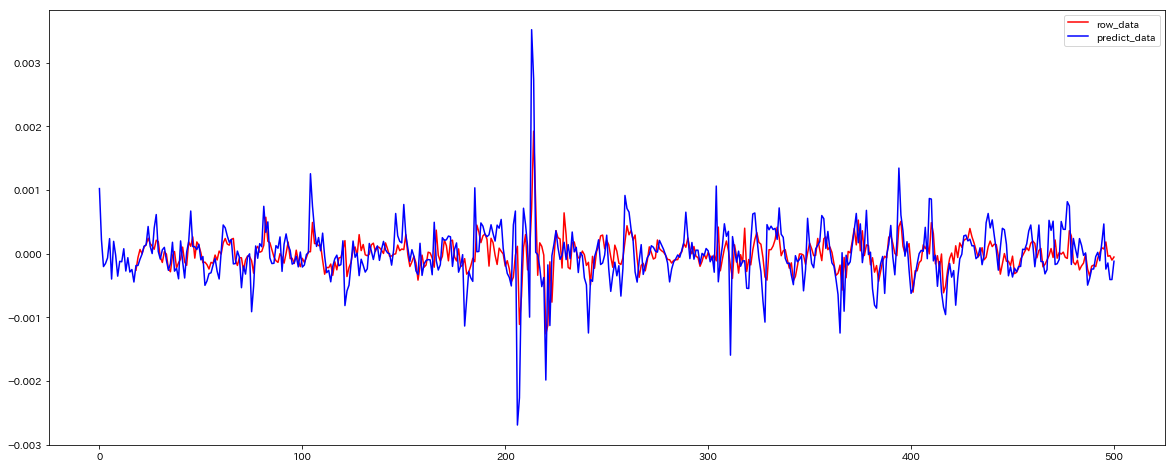

In [84]:
plt.figure(figsize=(20, 8))
plt.plot(range(18, len(summary)), ar_predict, color="r", label="row_data")
plt.plot(range(len(summary)), summary, color="b", label="predict_data")
plt.legend()
plt.show()

In [85]:
st.arma_order_select_ic(summary, ic='aic')

/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.6/site-packages/scipy/signal/signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.6/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.6/site-packages/scipy/signal/signaltools.py:1350: FutureWarning: Using a non-tuple sequence for multidimensional indexing is d

{'aic':              0            1            2
 0 -6287.360906 -6364.643058 -6368.802717
 1 -6369.231655 -6368.823973 -6366.845336
 2 -6368.763614 -6366.333219 -6364.854711
 3 -6366.922829 -6365.012256 -6383.438446
 4 -6365.806398 -6382.596365 -6376.535661, 'aic_min_order': (3, 2)}

In [88]:
arma = ARMA(summary, order=[3, 2]).fit()
arma_predict = arma.predict()

In [90]:
len(summary)
len(arma_predict)

501

501

<Figure size 1440x576 with 0 Axes>

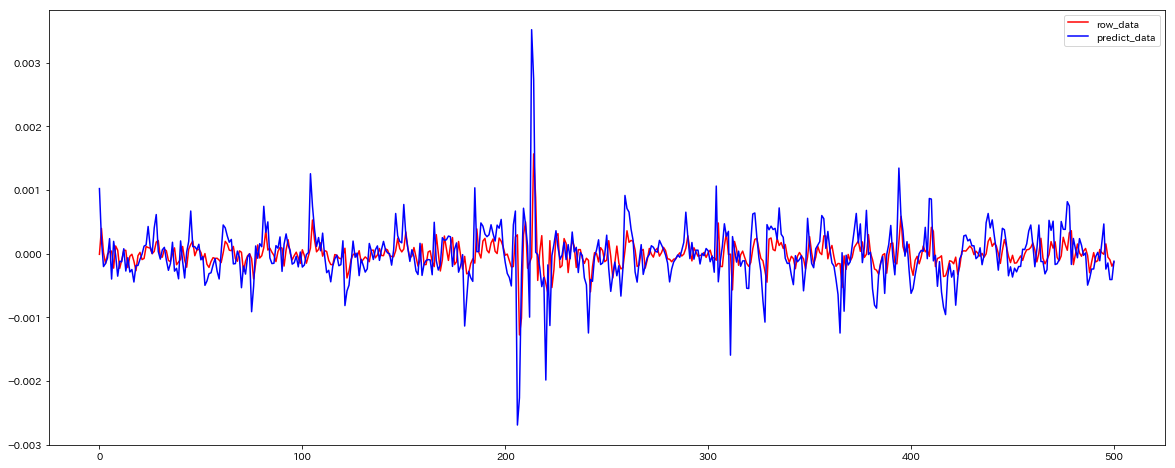

In [91]:
plt.figure(figsize=(20, 8))
plt.plot(range(len(summary)), arma_predict, color="r", label="row_data")
plt.plot(range(len(summary)), summary, color="b", label="predict_data")
plt.legend()
plt.show()

In [117]:
# arima = ARIMA(summary, order=[4,1,0]).fit(ic='aic')
arima = ARIMA(summary, order=[4, 1, 0]).fit()
# arima_predict = arima.predict()
arima_predict = -arima.predict()

In [118]:
len(summary)
len(arima_predict)

501

500

<Figure size 1440x576 with 0 Axes>

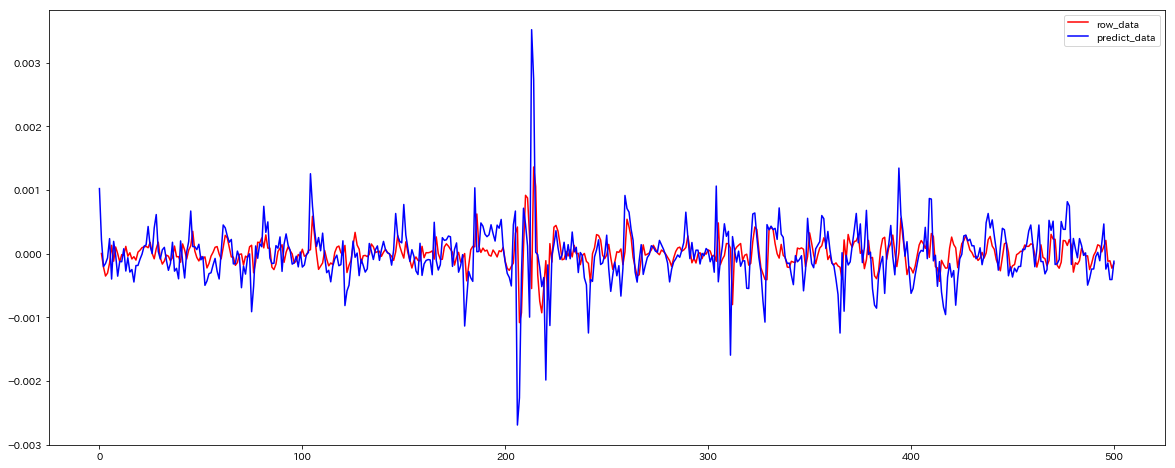

In [119]:
plt.figure(figsize=(20, 8))
plt.plot(range(1, len(summary)), arima_predict, color="r", label="row_data")
plt.plot(range(len(summary)), summary, color="b", label="predict_data")
plt.legend()
plt.show()

In [139]:
summary

,slope,lag1,lag2,lag3
3,-1.554315e-04,-2.043691e-04,2.176052e-04,1.021225e-03
4,-6.826501e-05,-1.554315e-04,-2.043691e-04,2.176052e-04
5,2.350235e-04,-6.826501e-05,-1.554315e-04,-2.043691e-04
6,-3.999764e-04,2.350235e-04,-6.826501e-05,-1.554315e-04
7,1.921707e-04,-3.999764e-04,2.350235e-04,-6.826501e-05
8,-2.537267e-05,1.921707e-04,-3.999764e-04,2.350235e-04
9,-3.548055e-04,-2.537267e-05,1.921707e-04,-3.999764e-04
10,-1.216807e-04,-3.548055e-04,-2.537267e-05,1.921707e-04
11,-1.287007e-04,-1.216807e-04,-3.548055e-04,-2.537267e-05
12,7.599513e-05,-1.287007e-04,-1.216807e-04,-3.548055e-04


# LightGBMとか機械学習系

In [142]:
from lightgbm import LGBMRegressor
lgb = LGBMRegressor()

In [170]:
summary = summarys['A'].loc[10000:10500, '傾き'].fillna(0).values
summary = pd.DataFrame({'slope': summary})
for i in range(50):
    summary[f'lag{i}'] = summary['slope'].shift(i)

summary = summary.dropna()

X_train = summary.drop(['slope'], axis=1)[:400].values
X_test = summary.drop(['slope'], axis=1)[400:].values

y_train = summary['slope'][:400].values
y_test = summary['slope'][400:].values

In [171]:
lgb.fit(X_train, y_train)
train_pred = lgb.predict(X_train)
test_pred = lgb.predict(X_test)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.1, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

<Figure size 1440x576 with 0 Axes>

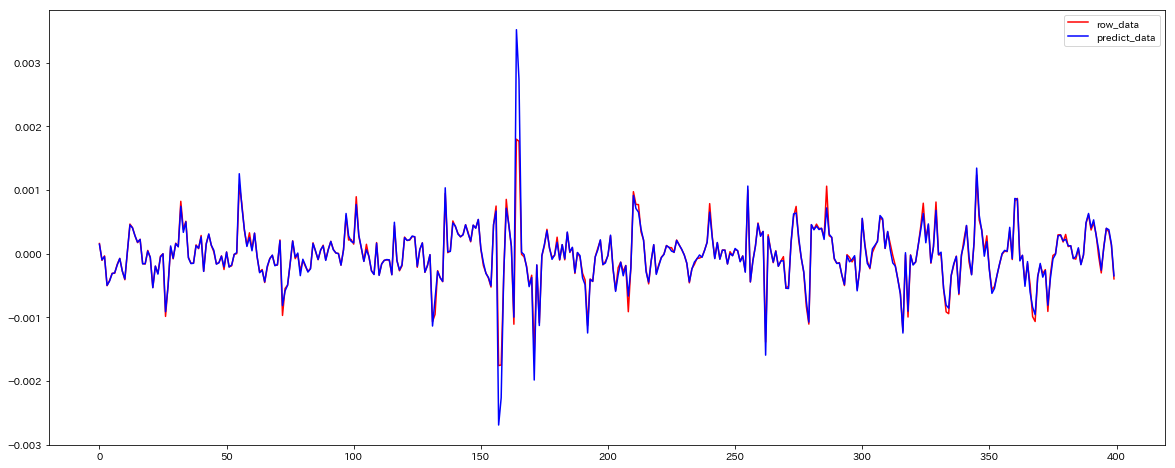

6.114000434957343e-06

In [172]:
plt.figure(figsize=(20, 8))
plt.plot(range(len(y_train)), train_pred, color="r", label="row_data")
plt.plot(range(len(y_train)), y_train, color="b", label="predict_data")
plt.legend()
plt.show()

sum((train_pred - y_train)**2)

<Figure size 1440x576 with 0 Axes>

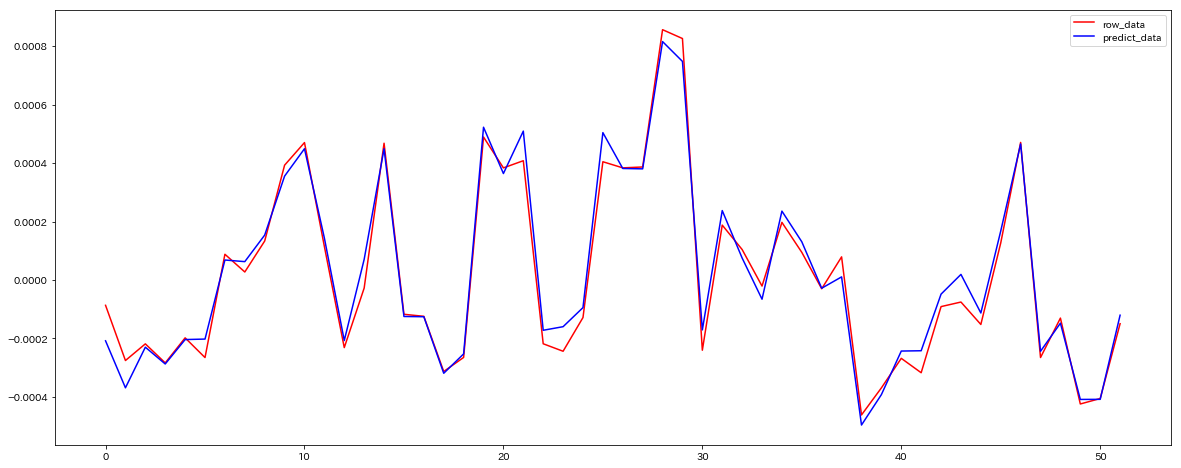

1.2445194322262883e-07

In [173]:
plt.figure(figsize=(20, 8))
plt.plot(range(len(y_test)), test_pred, color="r", label="row_data")
plt.plot(range(len(y_test)), y_test, color="b", label="predict_data")
plt.legend()
plt.show()

sum((test_pred - y_test)**2)

In [174]:
summary = summarys['A'].loc[10000:10500, '切片'].fillna(0).values
summary = pd.DataFrame({'slope': summary})
for i in range(50):
    summary[f'lag{i}'] = summary['slope'].shift(i)

summary = summary.dropna()

X_train = summary.drop(['slope'], axis=1)[:400].values
X_test = summary.drop(['slope'], axis=1)[400:].values

y_train = summary['slope'][:400].values
y_test = summary['slope'][400:].values

In [175]:
lgb.fit(X_train, y_train)
train_pred = lgb.predict(X_train)
test_pred = lgb.predict(X_test)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.1, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

<Figure size 1440x576 with 0 Axes>

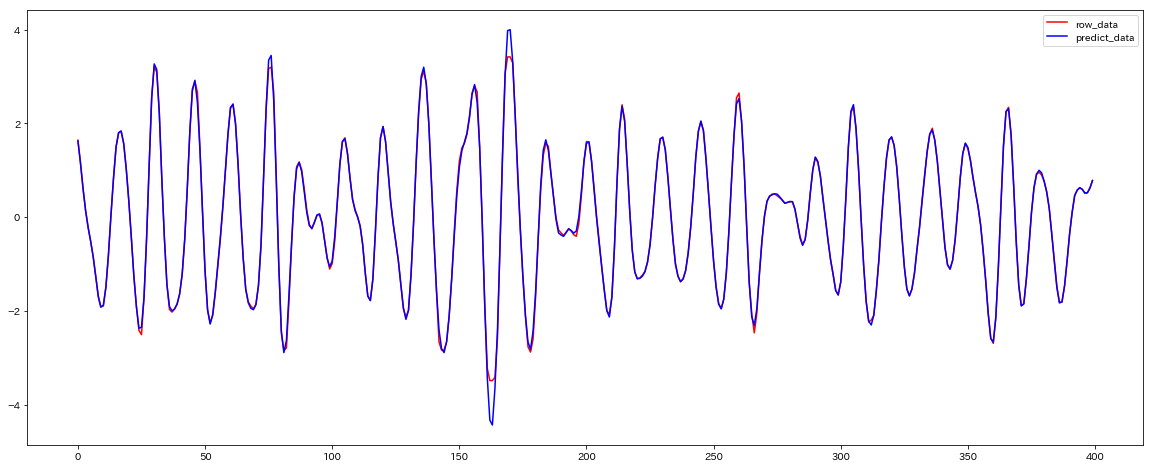

3.2140904644548254

In [176]:
plt.figure(figsize=(20, 8))
plt.plot(range(len(y_train)), train_pred, color="r", label="row_data")
plt.plot(range(len(y_train)), y_train, color="b", label="predict_data")
plt.legend()
plt.show()

sum((train_pred - y_train)**2)

<Figure size 1440x576 with 0 Axes>

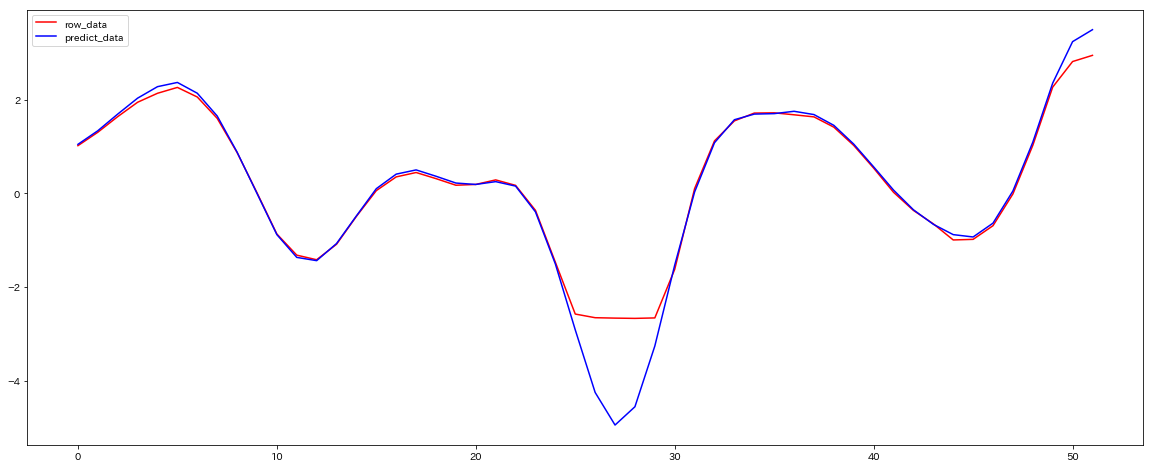

12.374782726197502

In [178]:
plt.figure(figsize=(20, 8))
plt.plot(range(len(y_test)), test_pred, color="r", label="row_data")
plt.plot(range(len(y_test)), y_test, color="b", label="predict_data")
plt.legend()
plt.show()

sum((test_pred - y_test)**2)

In [261]:
summary = summarys['A'].loc[10000:20000, '傾き'].fillna(0).values
summary = pd.DataFrame({'slope': summary})
for i in range(50):
    summary[f'lag{i}'] = summary['slope'].shift(i)

summary = summary.dropna()

X_train = summary.drop(['slope'], axis=1)[:8000].values
X_test = summary.drop(['slope'], axis=1)[8000:].values

y_train = summary['slope'][:8000].values
y_test = summary['slope'][8000:].values

In [262]:
lgb.fit(X_train, y_train)
train_pred = lgb.predict(X_train)
test_pred = lgb.predict(X_test)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.1, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

<Figure size 1440x576 with 0 Axes>

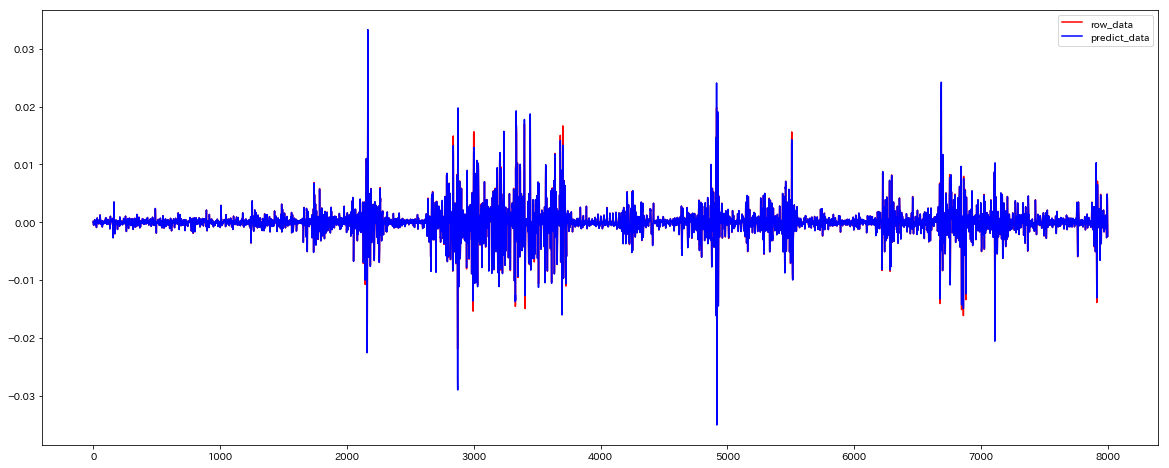

0.000679658429772202

In [263]:
plt.figure(figsize=(20, 8))
plt.plot(range(len(y_train)), train_pred, color="r", label="row_data")
plt.plot(range(len(y_train)), y_train, color="b", label="predict_data")
plt.legend()
plt.show()

sum((train_pred - y_train)**2)

<Figure size 1440x576 with 0 Axes>

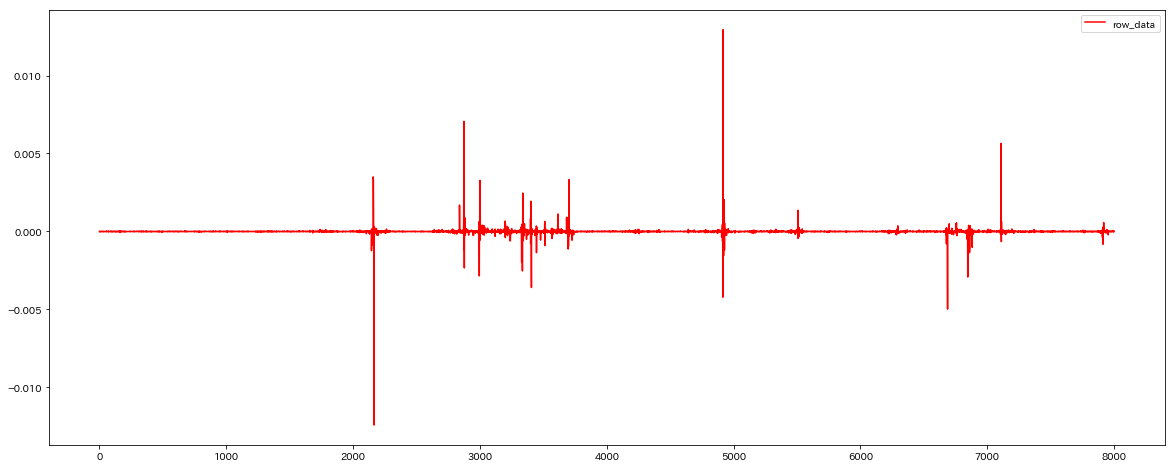

In [264]:
plt.figure(figsize=(20, 8))
plt.plot(range(len(y_train)), train_pred-y_train, color="r", label="row_data")
plt.legend()
plt.show()

In [265]:
[[i, train_pred[i]-y_train[i]] for i in range(len(y_train)) if abs(train_pred[i]-y_train[i]) > 0.005]
[[i, train_pred[i], y_train[i]] for i in range(len(y_train)) if abs(train_pred[i]-y_train[i]) > 0.005]

[[2166, -0.012407775487586436],
 [2873, 0.005000421433568124],
 [2874, 0.00706254003819257],
 [4917, 0.012936994130909086],
 [7109, 0.005645432869167072]]

[[2166, 0.0208679091964824, 0.033275684684068836],
 [2873, -0.02185488871274795, -0.026855310146316074],
 [2874, -0.021922043558963038, -0.028984583597155607],
 [4917, -0.02211055661170175, -0.03504755074261084],
 [7109, -0.014910019910409288, -0.02055545277957636]]

In [339]:
# summary = summarys['A'].loc[10000:20000, ['傾き']].fillna(0)#.sort_values('傾き')
summary = summarys['A'].loc[10000:20000].fillna(0)#.sort_values('傾き')
# summary = summarys['A'].loc[10000:20000, ['傾き']].fillna(0).values
# summary.index
# [i+10049 for i in range(len(y_train)) if abs(train_pred[i]-y_train[i]) > 0.005]
summary.loc[[i+10049 for i in range(len(y_train)) if abs(train_pred[i]-y_train[i]) > 0.005], :]

,路線,キロ程,傾き,切片,標本標準偏差,測定回数,データ数,バラスト,ロングレール,マクラギ種別,橋りょう,踏切,通トン,曲線半径,フラグ
12215,A,22988.0,0.033276,8.020,5.706044,280.0,40.0,1,1,1,0,0,12.237,2400,0
12922,A,23782.0,-0.026855,0.735,1.912607,287.0,70.0,1,0,1,0,0,11.059,0,1
12923,A,23783.0,-0.028985,-1.650,1.640978,285.0,69.0,1,0,1,0,0,11.059,0,1
14966,A,26070.0,-0.035048,-8.640,3.959079,226.0,44.0,0,0,5,1,0,11.059,0,0
17158,A,28511.0,-0.020555,-5.685,1.048213,75.0,13.0,1,1,1,0,0,11.086,1200,0


In [250]:
tracks={}
for no in ['A','B','C','D']:
    tracks[no] = pd.read_csv("dataset/track_" + no + ".csv", parse_dates=["date"])

In [316]:
summarys = {}
for no in ['A', 'B', 'C', 'D']:
    summarys[no] = pd.read_csv(f'summary4_{no}.csv', index_col=0)

In [317]:
def get_day(dates):
    day = [(date - datetime.datetime(2017, 4, 1)).days for date in dates]
    return day

In [318]:
submit = pd.DataFrame()
for no in ['A', 'B', 'C', 'D']:
    track = tracks[no]
    summary = summarys[no]
    summary = summary.dropna()

    sub = pd.DataFrame()
    sub['キロ程'] = track['キロ程'].unique()
    sub['路線'] = no

    kilos = summary['キロ程'].values
    inds = kilos.astype(int) - 10000

    sub.loc[inds, '傾き'] = summary['傾き'].values
    sub.loc[inds, '切片'] = summary['切片'].values
    
    submit = pd.concat([submit, sub], axis=0)
submit = submit.reset_index(drop=True)

In [319]:
submit.loc[submit['傾き'] == -100, '傾き'] = np.median(submit.loc[submit['傾き'].notnull(), '傾き'])
submit.loc[submit['傾き'].isnull(), '傾き'] = np.median(submit.loc[submit['傾き'].notnull(), '傾き'])
submit.loc[submit['切片'].isnull(), '切片'] = np.median(submit.loc[submit['切片'].notnull(), '切片'])

In [320]:
p = []
last_median_day = 30
for no in ['A', 'B', 'C', 'D']:
    tmp = submit[submit['路線'] == no]
    for i in range(91):
        day = tmp['切片'].values + tmp['傾き'].values*(i+last_median_day//2)
        p.extend(day)

submision = pd.DataFrame(p)
print(sum(submision.isnull()))
submision = submision.fillna(0)
submision = submision.apply(lambda x:x.round(2))

0


In [321]:
submision.loc[submision[0] > 16, 0] = 16
submision.loc[submision[0] < -16, 0] = -16

In [322]:
import random

Text(0.5, 1.0, 'kilo: 22988.0')

Text(0.5, 1.0, 'kilo: 23782.0')

Text(0.5, 1.0, 'kilo: 23783.0')

Text(0.5, 1.0, 'kilo: 26070.0')

Text(0.5, 1.0, 'kilo: 28511.0')

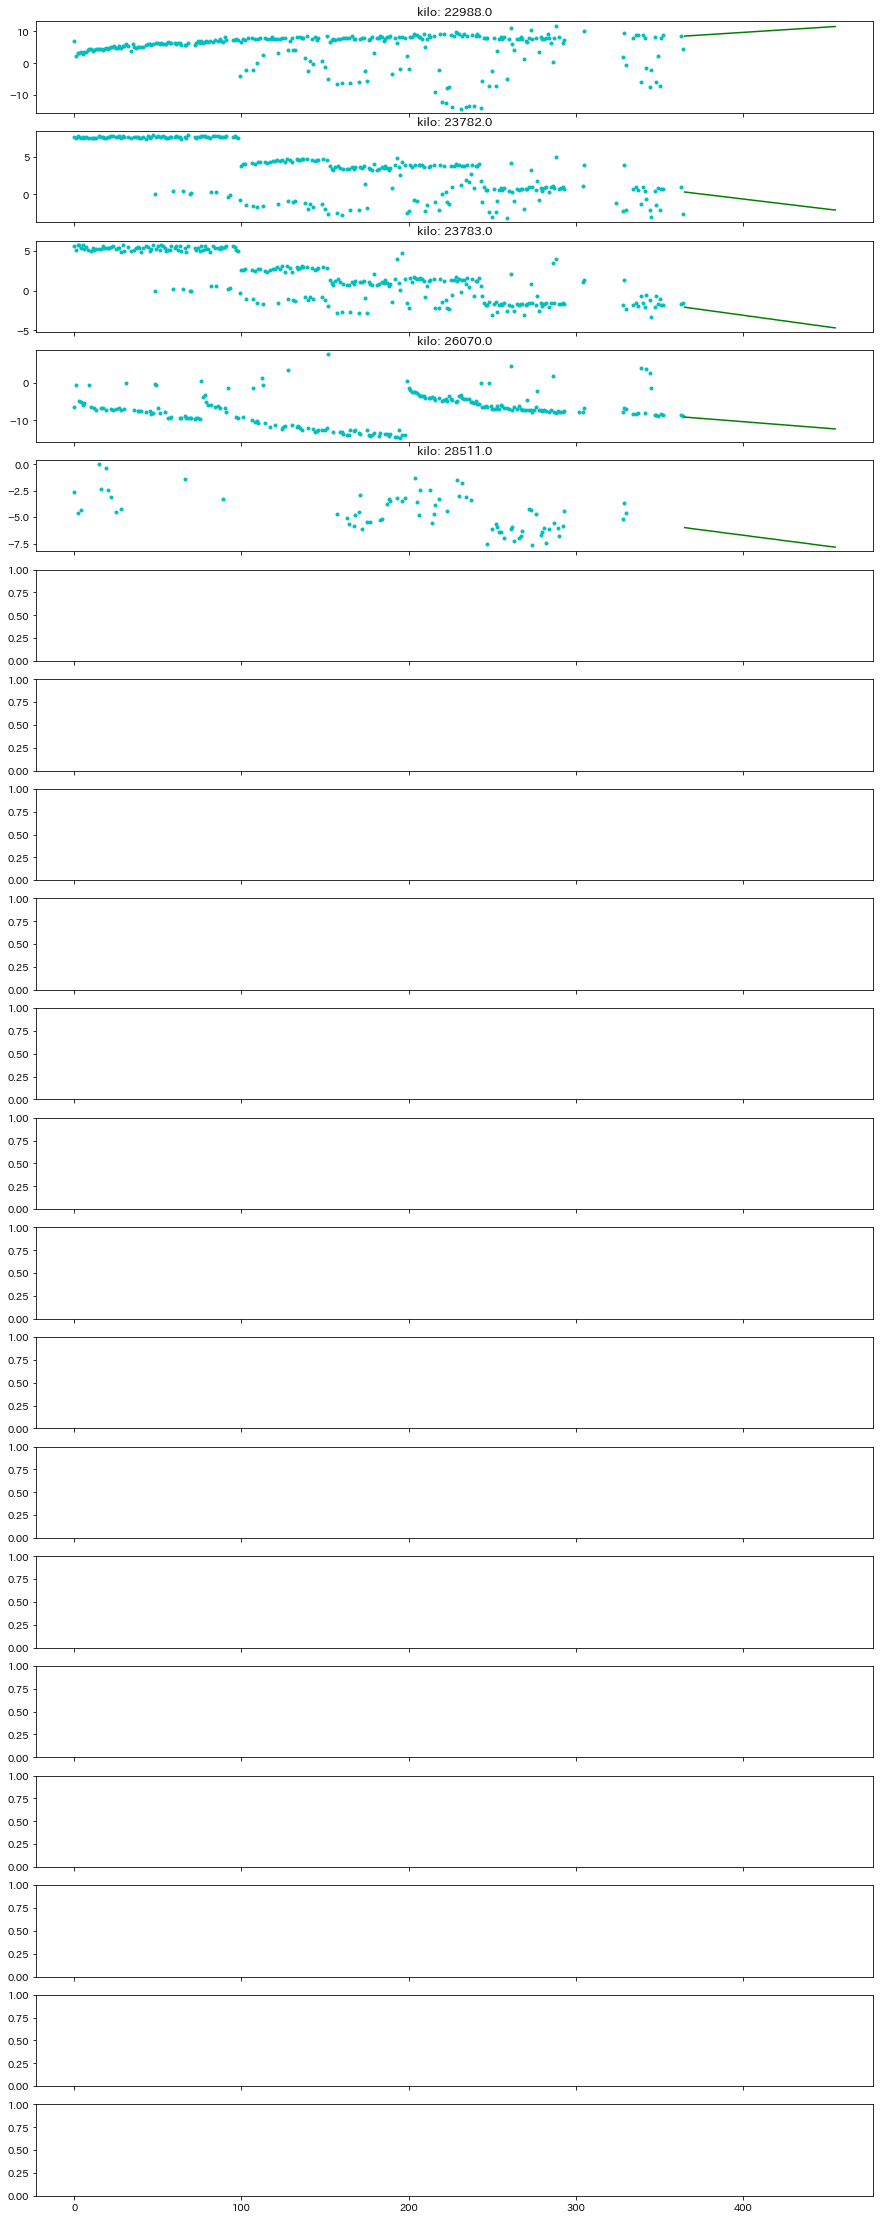

In [341]:
fig, axes = plt.subplots(20, 1, figsize=(15, 40), sharex=True)

track = tracks['A']
# summary = summarys['A']
summary = summarys['A'].loc[10000:20000]

# random.seed(0)
# tmp = track['キロ程'].unique()
# kilos = random.sample(list(tmp), 20)
kilos = summary.loc[[i+10049 for i in range(len(y_train)) if abs(train_pred[i]-y_train[i]) > 0.005], :]['キロ程'].values
for i, kilo in enumerate(kilos):
    data = track.loc[track['キロ程'] == kilo, ['date', '高低左']]
    data = data.dropna(subset=['高低左'])
    data = data.reset_index(drop=True)
    data['day'] = get_day(data['date'])
    data = data.drop(['date'], axis=1)
    axes[i].plot(data['day'], data['高低左'], marker='.', linewidth=0, c='c')

    kilo_id = kilo - 10000
    hoge = [kilo_id + i*len(tmp) for i in range(91)]
    piyo = submision.loc[hoge, 0]
    axes[i].plot(range(365, 365 + 91), piyo, c='g')

    axes[i].set_title(f'kilo: {kilo}')

In [265]:
[[i, train_pred[i]-y_train[i]] for i in range(len(y_train)) if abs(train_pred[i]-y_train[i]) > 0.005]
[[i, train_pred[i], y_train[i]] for i in range(len(y_train)) if abs(train_pred[i]-y_train[i]) > 0.005]

[[2166, -0.012407775487586436],
 [2873, 0.005000421433568124],
 [2874, 0.00706254003819257],
 [4917, 0.012936994130909086],
 [7109, 0.005645432869167072]]

[[2166, 0.0208679091964824, 0.033275684684068836],
 [2873, -0.02185488871274795, -0.026855310146316074],
 [2874, -0.021922043558963038, -0.028984583597155607],
 [4917, -0.02211055661170175, -0.03504755074261084],
 [7109, -0.014910019910409288, -0.02055545277957636]]

<Figure size 1440x576 with 0 Axes>

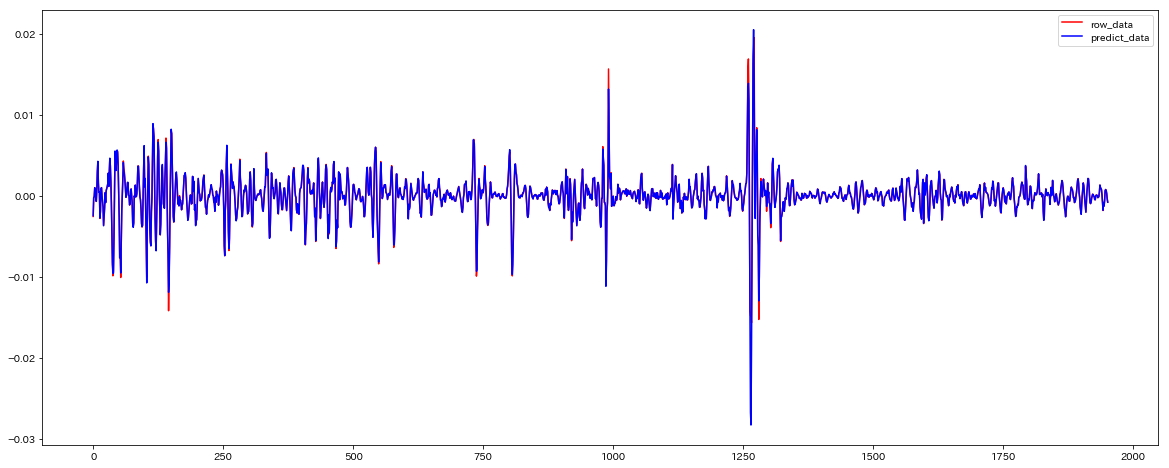

0.0004058436321905554

In [182]:
plt.figure(figsize=(20, 8))
plt.plot(range(len(y_test)), test_pred, color="r", label="row_data")
plt.plot(range(len(y_test)), y_test, color="b", label="predict_data")
plt.legend()
plt.show()

sum((test_pred - y_test)**2)

<Figure size 1440x576 with 0 Axes>

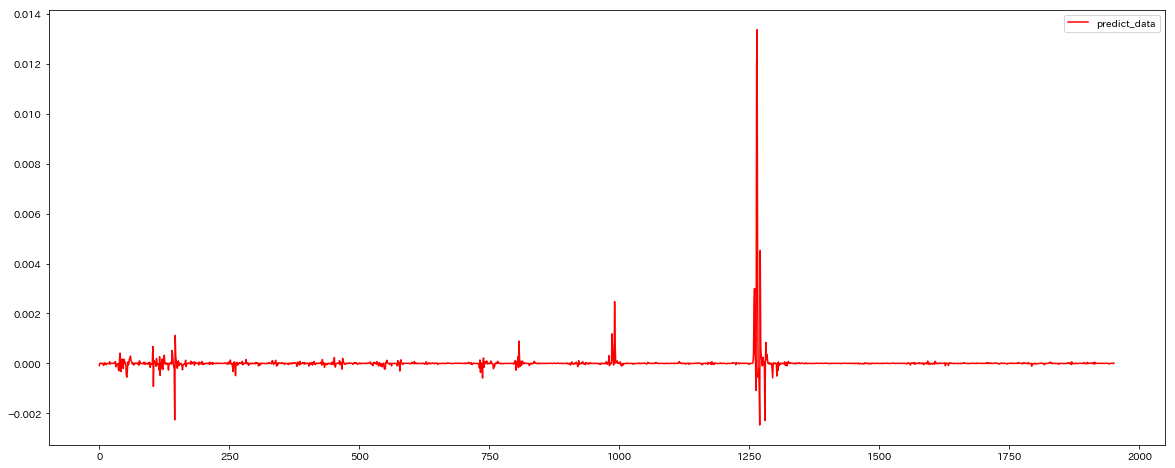

In [244]:
plt.figure(figsize=(20, 8))
plt.plot(range(len(y_test)), test_pred-y_test, color="r", label="predict_data")
plt.legend()
plt.show()

In [183]:
summary = summarys['A'].loc[10000:20000, '切片'].fillna(0).values
summary = pd.DataFrame({'slope': summary})
for i in range(50):
    summary[f'lag{i}'] = summary['slope'].shift(i)

summary = summary.dropna()

X_train = summary.drop(['slope'], axis=1)[:8000].values
X_test = summary.drop(['slope'], axis=1)[8000:].values

y_train = summary['slope'][:8000].values
y_test = summary['slope'][8000:].values

In [184]:
lgb.fit(X_train, y_train)
train_pred = lgb.predict(X_train)
test_pred = lgb.predict(X_test)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.1, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

<Figure size 1440x576 with 0 Axes>

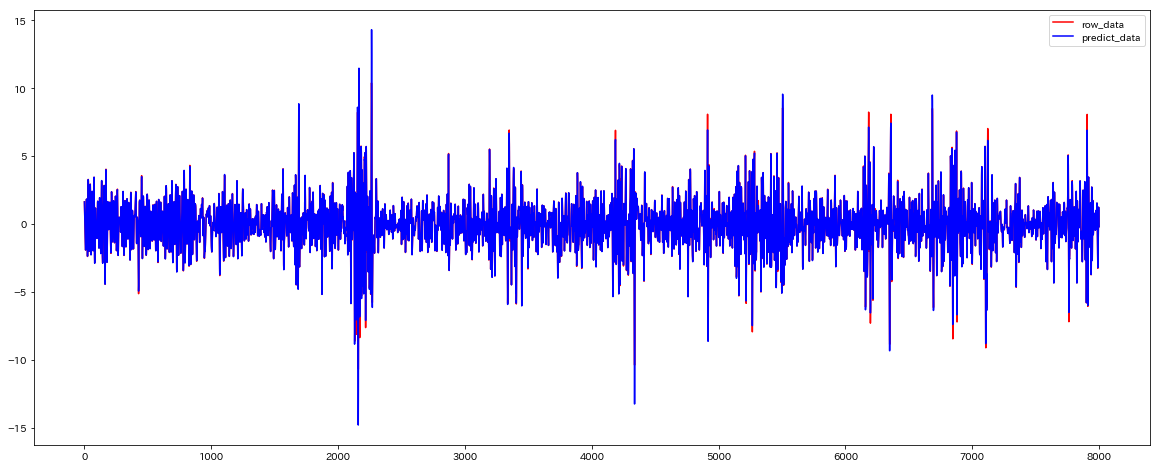

130.30626625891682

In [185]:
plt.figure(figsize=(20, 8))
plt.plot(range(len(y_train)), train_pred, color="r", label="row_data")
plt.plot(range(len(y_train)), y_train, color="b", label="predict_data")
plt.legend()
plt.show()

sum((train_pred - y_train)**2)

<Figure size 1440x576 with 0 Axes>

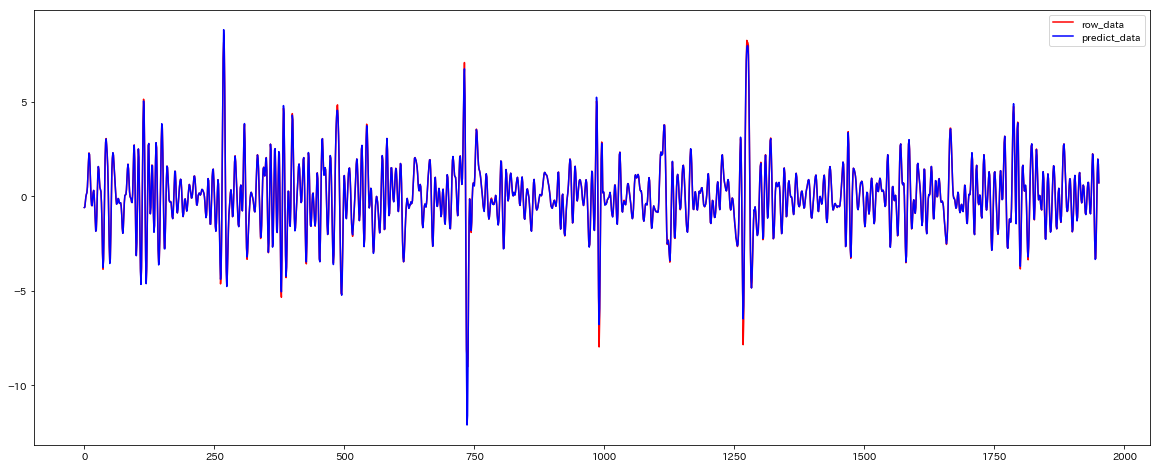

27.612288130086508

In [186]:
plt.figure(figsize=(20, 8))
plt.plot(range(len(y_test)), test_pred, color="r", label="row_data")
plt.plot(range(len(y_test)), y_test, color="b", label="predict_data")
plt.legend()
plt.show()

sum((test_pred - y_test)**2)

In [245]:
test_pred-y_test

array([-8.84262374e-05,  4.44757930e-06, -6.71010849e-06, ...,
       -3.03703132e-06, -6.07734663e-06,  1.29567008e-05])

In [225]:
equipments={}
for no in ['A','B','C','D']:
    equipments[no] = pd.read_csv("dataset/equipment_" + no + ".csv")
    equipments[no] = equipments[no].drop(['キロ程'], axis=1)
    equipments[no]['マクラギ種別'] = equipments[no]['マクラギ種別'].astype('category')
    equipments[no] = pd.get_dummies(equipments[no])
    equipments[no]['曲線半径'] = 1/(equipments[no]['曲線半径'] + 100000)

In [234]:
equipments['A'].loc[:10000, :]

,バラスト,ロングレール,橋りょう,踏切,通トン,曲線半径,フラグ,マクラギ種別_1,マクラギ種別_2,マクラギ種別_3,マクラギ種別_5,マクラギ種別_6,マクラギ種別_8
0,1,1,0,0,13.607,0.00001,1,0,0,1,0,0,0
1,1,1,0,0,13.607,0.00001,1,0,0,1,0,0,0
2,1,1,0,0,13.607,0.00001,1,0,0,1,0,0,0
3,1,1,0,0,13.607,0.00001,1,0,0,1,0,0,0
4,1,1,0,0,13.607,0.00001,1,1,0,0,0,0,0
5,1,1,0,0,13.607,0.00001,1,1,0,0,0,0,0
6,1,1,0,0,13.607,0.00001,1,1,0,0,0,0,0
7,1,1,0,0,13.607,0.00001,1,1,0,0,0,0,0
8,1,1,0,0,13.607,0.00001,1,1,0,0,0,0,0
9,1,1,0,0,13.607,0.00001,1,1,0,0,0,0,0


In [232]:
summary = pd.DataFrame(summarys['A'].loc[:10000, '傾き'].fillna(0))
equipment = equipments['A'].loc[:10000, :]

lag = 30
for i in range(lag):
    summary[f'lag_{i}'] = summary['傾き'].shift(i)

summary = pd.concat([summary, equipment], axis=1)
summary = summary.dropna()

X_train = summary.drop(['傾き'], axis=1)[:8000]
X_test = summary.drop(['傾き'], axis=1)[8000:]

y_train = summary['傾き'][:8000]
y_test = summary['傾き'][8000:]

In [233]:
summary

,傾き,lag_0,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,...,踏切,通トン,曲線半径,フラグ,マクラギ種別_1,マクラギ種別_2,マクラギ種別_3,マクラギ種別_5,マクラギ種別_6,マクラギ種別_8
29,0.003436,0.003436,0.000839,0.000528,0.000577,-0.000284,-0.001919,-0.002721,-0.001452,-0.000783,...,0,13.607,0.00001,0,1,0,0,0,0,0
30,0.004448,0.004448,0.003436,0.000839,0.000528,0.000577,-0.000284,-0.001919,-0.002721,-0.001452,...,0,13.607,0.00001,0,1,0,0,0,0,0
31,0.003791,0.003791,0.004448,0.003436,0.000839,0.000528,0.000577,-0.000284,-0.001919,-0.002721,...,0,13.607,0.00001,0,1,0,0,0,0,0
32,0.001119,0.001119,0.003791,0.004448,0.003436,0.000839,0.000528,0.000577,-0.000284,-0.001919,...,0,13.607,0.00001,0,1,0,0,0,0,0
33,0.000372,0.000372,0.001119,0.003791,0.004448,0.003436,0.000839,0.000528,0.000577,-0.000284,...,0,13.607,0.00001,0,1,0,0,0,0,0
34,-0.005632,-0.005632,0.000372,0.001119,0.003791,0.004448,0.003436,0.000839,0.000528,0.000577,...,0,13.607,0.00001,0,1,0,0,0,0,0
35,-0.005629,-0.005629,-0.005632,0.000372,0.001119,0.003791,0.004448,0.003436,0.000839,0.000528,...,0,13.607,0.00001,0,1,0,0,0,0,0
36,-0.002027,-0.002027,-0.005629,-0.005632,0.000372,0.001119,0.003791,0.004448,0.003436,0.000839,...,0,13.607,0.00001,0,1,0,0,0,0,0
37,-0.000286,-0.000286,-0.002027,-0.005629,-0.005632,0.000372,0.001119,0.003791,0.004448,0.003436,...,0,13.607,0.00001,0,1,0,0,0,0,0
38,-0.001134,-0.001134,-0.000286,-0.002027,-0.005629,-0.005632,0.000372,0.001119,0.003791,0.004448,...,0,13.607,0.00001,0,1,0,0,0,0,0


In [235]:
lgb.fit(X_train, y_train)
train_pred = lgb.predict(X_train)
test_pred = lgb.predict(X_test)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.1, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

<Figure size 1440x576 with 0 Axes>

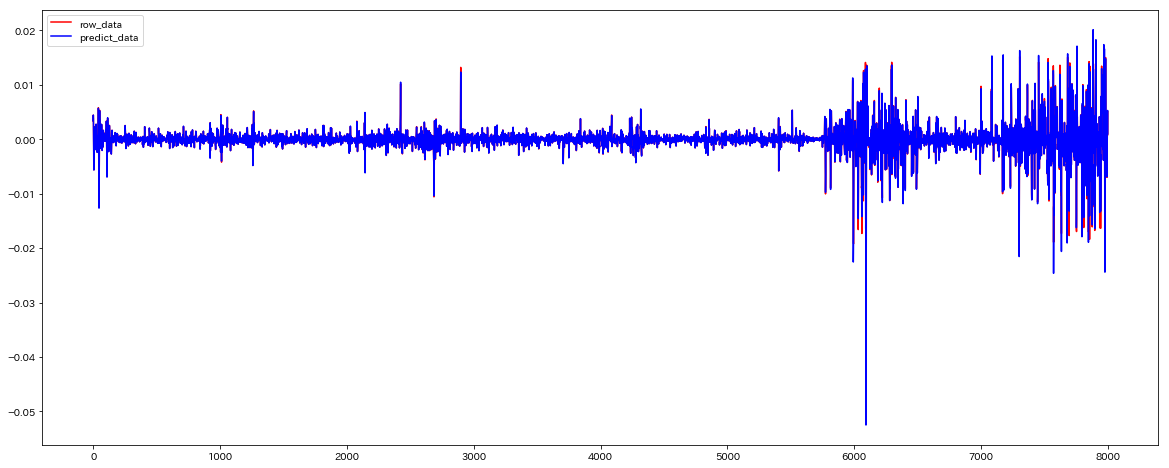

0.0011732753932064053

In [236]:
plt.figure(figsize=(20, 8))
plt.plot(range(len(y_train)), train_pred, color="r", label="row_data")
plt.plot(range(len(y_train)), y_train, color="b", label="predict_data")
plt.legend()
plt.show()

sum((train_pred - y_train)**2)

<Figure size 1440x576 with 0 Axes>

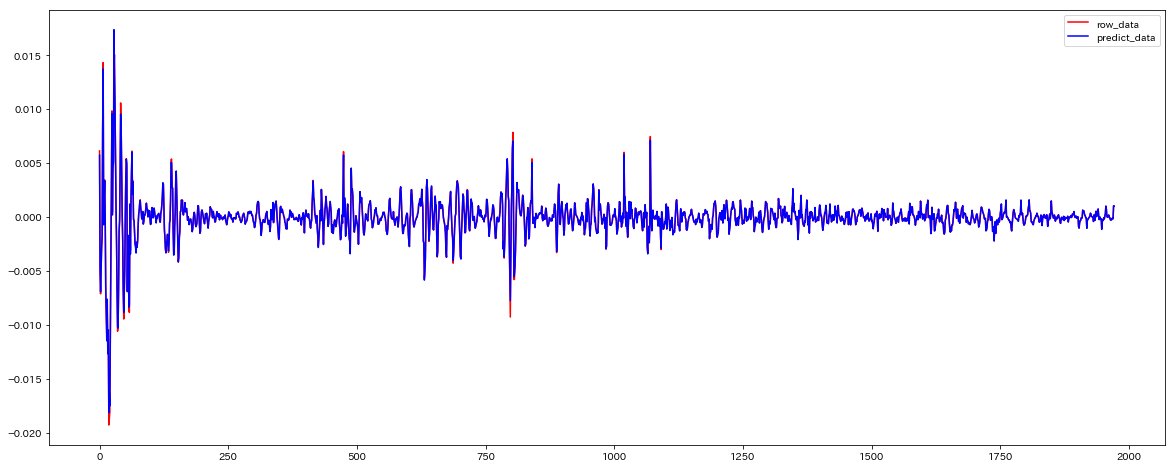

3.901586566712432e-05

In [237]:
plt.figure(figsize=(20, 8))
plt.plot(range(len(y_test)), test_pred, color="r", label="row_data")
plt.plot(range(len(y_test)), y_test, color="b", label="predict_data")
plt.legend()
plt.show()

sum((test_pred - y_test)**2)

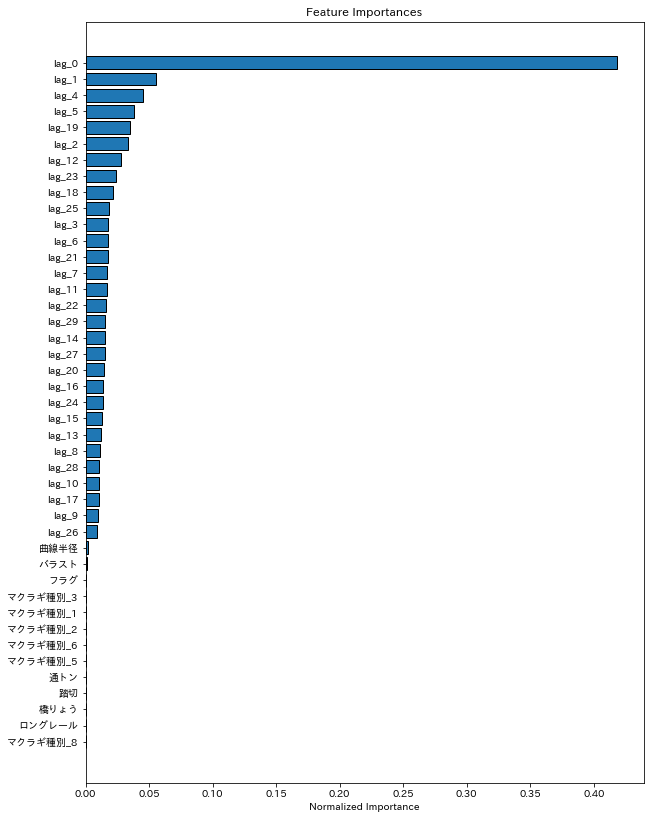

,index,feature,importance,importance_normalized
0,0,lag_0,1255,0.418333
1,1,lag_1,167,0.0556667
2,4,lag_4,136,0.0453333
3,5,lag_5,115,0.0383333
4,19,lag_19,104,0.0346667
5,2,lag_2,101,0.0336667
6,12,lag_12,83,0.0276667
7,23,lag_23,73,0.0243333
8,18,lag_18,64,0.0213333
9,25,lag_25,56,0.0186667


In [238]:
def plot_feature_importances(df, n_feat):
    df = df.sort_values('importance', ascending = False).reset_index()
    df['importance_normalized'] = df['importance'] / df['importance'].sum()
    plt.figure(figsize = (10, n_feat//3))
    ax = plt.subplot()
    ax.barh(list(reversed(list(df.index[:n_feat]))), 
            df['importance_normalized'].head(n_feat),
            align = 'center', edgecolor = 'k')
    ax.set_yticks(list(reversed(list(df.index[:n_feat]))))
    ax.set_yticklabels(df['feature'].head(n_feat))
    plt.xlabel('Normalized Importance')
    plt.title('Feature Importances')
    plt.show()
    return df

n_feat = len(X_test.columns)
df = pd.DataFrame([X_test.columns, lgb.feature_importances_], index=['feature', 'importance'])
df = df.T
plot_feature_importances(df, n_feat)
del df

In [ ]:
summ